# Homework 3


You will train a recurrent neural network that takes a code snippet and predicts which programming language it is written in. 

The dataset contains 11103 snippets for train and 2995 snippets for test from 6 programming languages: C++, C#, Python, JavaScript, HTML and SQL. Each programming language is almost equaly represented in the dataset.  The dataset is found in the course Google Drive folder lab03-tema03/\*-data-split, each snippets in a separate file and the labels are stored as dictionary in  lab03-tema03/code-\*-gt.json using filename as identifier. The dataset is a subset of the dataset used in [deep-learning-lang-detection](https://github.com/aliostad/deep-learning-lang-detection), that we cut in chunks of length 1000.

Your task is to investigate the best network architecture for this problem tuning RNN's hyperparameters (temperature, hidden_size) and  the maximum length of sequences used for training (you don't have to use the entire sequence of 1000 characters given in dataset).

For your models you have to report: \\
1.  Accuracy of the model on test set computed as: $\frac{\#correct\ predictions}{\#total\ predictions}$
2.   Confusion matrix: a matrix of $6 \times 6$ where $M_{i,j}$ is the number of examples from class $i$ classified by your model as $j$. How do you interpret these results?




 







In [2]:
from google.colab import files, auth, drive
from urllib.request import urlopen
from typing import List, Dict, Callable
from collections import Counter
from os import path
import numpy as np
import torch
from torch import nn
from torch.optim import SGD, Adam
from matplotlib import pyplot as plt
import glob
import unicodedata
import string

############################## CONSTANTS #######################################
def findFiles(path): return glob.glob(path)

def readfile(filepath: str) -> str:
    """
    Reads file and returns its content as a string.
    """
    #response = urlopen(url)
    #body = response.read().decode('utf-8')
    with open(filepath, "r") as f:
        body = f.read()
    
    return body.encode('ascii', 'ignore').decode("utf-8")

ROOT_COLAB_FOLDER = "/content"
filename = "*.txt" #modify filename here
filepath = path.join(ROOT_COLAB_FOLDER, filename)
print(findFiles(filepath))

category_code = {}
all_categories = []
  
for filename in findFiles(filepath):
    category = filename[len(ROOT_COLAB_FOLDER) + 1:filename.find('.txt')]
    print(category)
    all_categories.append(category)
    code = readfile(filename)
    category_code[category] = code

n_categories = len(all_categories)

#make sure the text is properly read
for i in all_categories:
  print()
  print("Size of text " + i + " characters: " + str(len(category_code[i])))
  print("First 300 characters: \n", category_code[i][0:300])

[]


In [0]:
class Vocabulary:
    """
    Helper class that maps characters to unique indices and the other way around
    """
    def __init__(self, text: str):
        #special character for padding shorter sequences in a mini-batch
        characters_set = set("<PAD>") 
        characters_set.update(text)
        
        self.char_to_idx = {char:idx for (idx, char) 
                            in enumerate(characters_set)}
        self.idx_to_char = {idx:char for (idx, char) 
                            in enumerate(characters_set)}
   
    def size(self):
        return len(self.char_to_idx)
      
    def __str__(self):
        return str(self.char_to_idx)

text = ""
for i in all_categories:
  text = text + category_code[i]

vocab = Vocabulary(text)
print("Vocabulary size: ", vocab.size())
print("Vocabulary: \n", vocab)

Vocabulary size:  98
Vocabulary: 
 {'?': 0, '_': 1, 'J': 2, 'n': 3, '}': 4, '^': 5, 'C': 6, 'w': 7, 'j': 8, 'E': 9, 'D': 10, 'o': 11, '$': 12, '6': 13, 'p': 14, '3': 15, '(': 16, '5': 17, 'f': 18, '\x01': 19, 'b': 20, '`': 21, '#': 22, '&': 23, 'Y': 24, 'y': 25, '4': 26, ')': 27, ' ': 28, ']': 29, '[': 30, '|': 31, 'I': 32, '!': 33, 't': 34, 'i': 35, 'B': 36, 'A': 37, 'O': 38, '1': 39, '@': 40, '.': 41, 'e': 42, 'z': 43, 'a': 44, '\n': 45, 'g': 46, 'r': 47, '-': 48, 'R': 49, 'h': 50, 'l': 51, 'H': 52, 'Z': 53, 'W': 54, 'Q': 55, '7': 56, 'd': 57, '\\': 58, 's': 59, '*': 60, ',': 61, '<': 62, ';': 63, "'": 64, 'N': 65, 'U': 66, 'k': 67, '2': 68, 'T': 69, 'V': 70, 'K': 71, '{': 72, 'P': 73, 'F': 74, 'G': 75, '%': 76, '~': 77, 'S': 78, '0': 79, '"': 80, '>': 81, '+': 82, '9': 83, 'M': 84, '=': 85, 'c': 86, 'u': 87, '8': 88, ':': 89, 'X': 90, 'L': 91, 'x': 92, 'q': 93, 'm': 94, 'v': 95, '\t': 96, '/': 97}


In [0]:
def text_to_tensor(text: str, vocab: Vocabulary) -> torch.LongTensor:
    """
    Convert a string to a Tensor with corresponding character indices
    e.g. "We have" -> [12, 6, 20, 13, 1, 25, 6] 
    """
    text_indices = [vocab.char_to_idx[c] for c in text]
    
    return torch.tensor(text_indices)
  
def tensor_to_text(x: torch.LongTensor, vocab: Vocabulary) -> str:
    """
    Convert a Tensor of character indices to its string representation
    e.g. [12, 6, 20, 13, 1, 25, 6] -> "We have"
    """
    return "".join(vocab.idx_to_char[idx.item()] for idx in x)

def batch_tensor_to_text(x: torch.LongTensor, vocab: Vocabulary) -> List[str]:
    """
    The batched version of tensor_to_text
    E.g. [[2, 1, 3, 0, 0], [3, 1, 20]] -> [bac, cat]
    :param x: Tensor of size (batch_size x time_steps)
    :return: a list of corresponding strings 
    """
    assert len(x.size()) == 2, "wrong number of dimensions (should be 2)"
    outputs = []
    for batch_idx in range(len(x)):
        outputs.append(tensor_to_text(x[batch_idx], vocab))
            
    return outputs 
  
#check that a random text is correctly converted to numbers and back to text
random_text = "I have apples"
encoded_text = text_to_tensor(random_text, vocab)
decoded_text = tensor_to_text(encoded_text, vocab)
assert random_text == decoded_text, "Not the same text as the original"
print(encoded_text)
print(decoded_text)

#convert input text to numbers
data = {}
for i in all_categories:
  print(i)
  data[i] = text_to_tensor(category_code[i], vocab)
  print("Size of input tensor is: ", data[i].size(0))
  print()

#setup device (CPU/GPU)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

    
print(device)
#move tensor to CUDA if available
for i in all_categories:
  data[i] = data[i].to(device)

tensor([32, 28, 50, 44, 95, 42, 28, 44, 14, 14, 51, 42, 59])
I have apples
c++
Size of input tensor is:  2197116

Python
Size of input tensor is:  1632935

Java
Size of input tensor is:  1549090

JavaScript
Size of input tensor is:  1201462

c#
Size of input tensor is:  2094366

SQL
Size of input tensor is:  2623772

cuda:0


In [0]:
def make_batches(x: torch.LongTensor, batch_size: int, max_len: int) -> \
            (List[torch.LongTensor], List[torch.LongTensor]):
    """
    Returns a list of Tensors of size (batch_size x max_len), that represent
    the inputs and outputs for each feedforward call through the network
    :param x: Tensor of size textsize
    :param batch_size: number of examples 'seen' at a time
    :param max_len: number of steps to unroll the RNN
    """
    #ensure full batches (trim extra-content)
    text_size = len(x)
    num_iterations = text_size // (batch_size * max_len)
    assert num_iterations > 0, "large batch_size/max_len or short text"
    trimmed_size = num_iterations * batch_size * max_len
    x_trim = x[:trimmed_size]   
    #B x (T x num_iter)
    x_trim = x_trim.reshape((batch_size, -1))
       
    #we'll use T=0 (shifted upwards) as the last prediction
    first_column = x_trim[:, 0].clone()
    first_column[:-1] = first_column[1:]
    
    x_batches = [] #inputs
    y_batches = [] #outputs (inputs shifted to the left by one)
    for iter in range(0, (num_iterations-1) * max_len, max_len):
        #Tensors of size (batch_size x max_len)
        current_x = x_trim[:, iter: iter + max_len]
        current_y = torch.zeros_like(current_x)
        current_y[:,:] = x_trim[:, iter + 1: iter + max_len + 1]
        yield current_x, current_y
        
    iter += max_len
    current_x = x_trim[:, iter: iter + max_len]
    current_y = torch.zeros_like(current_x)
    current_y[:,:-1] = x_trim[:, iter + 1: iter + max_len]
    current_y[:,-1] = first_column
    print(current_x.shape)
    print(current_y)
    
    yield current_x, current_y

In [0]:
#split corpus into training/eval set
train_data = {}
dev_data = {}

for i in all_categories:
  train_dev_cutoff = int(len(data[i]) * 0.8)
  train_data[i], dev_data[i] = data[i][:train_dev_cutoff], data[i][train_dev_cutoff:]
  print(i)
  print("Training set size = ", len(train_data[i]))
  print("Evaluation set size = ", len(dev_data[i]))
  print()
  

c++
Training set size =  1757692
Evaluation set size =  439424

Python
Training set size =  1306348
Evaluation set size =  326587

Java
Training set size =  1239272
Evaluation set size =  309818

JavaScript
Training set size =  961169
Evaluation set size =  240293

c#
Training set size =  1675492
Evaluation set size =  418874

SQL
Training set size =  2099017
Evaluation set size =  524755



In [0]:
def print_sep(s: str, max_string_len: int):
    num_rows = len(s) // max_string_len
    for i in range(0, len(s), max_string_len):
        print("|" + s[i:i+max_string_len] + "|")

print("First 250 characters: \n")
print_sep(tensor_to_text(train_data['c++'][:250], vocab), 15)

#CHECKPOINT: verify the batches are correctly split
it = make_batches(train_data['c++'][0:250], 2, 15)
xb, yb = next(it)
print("First batch input: ", batch_tensor_to_text(xb, vocab))
print("First batch output: ", batch_tensor_to_text(yb, vocab))

xb2, yb2 = next(it)
print("Second batch input: ", batch_tensor_to_text(xb2, vocab))
print("Second batch output: ", batch_tensor_to_text(yb2, vocab))

First 250 characters: 

|namespace grace|
| {
	FormattedSt|
|ream& operator<|
|<(FormattedStre|
|am& stream, con|
|st char *cstr) |
|{
		stream.writ|
|e((const byte*)|
|cstr, strlen(cs|
|tr));
		return |
|stream;
	}
	For|
|mattedStream& o|
|perator<<(Forma|
|ttedStream& str|
|eam, const Stri|
|ng& str) {
		st|
|ream.write|
First batch input:  ['namespace grace', 'cstr, strlen(cs']
First batch output:  ['amespace grace ', 'str, strlen(cst']
Second batch input:  [' {\n\tFormattedSt', 'tr));\n\t\treturn ']
Second batch output:  ['{\n\tFormattedStr', 'r));\n\t\treturn s']


In [0]:
char_idx = torch.LongTensor([7])

#create one-hot representation for 7
#this is a vector of zeroes, except for the 7th position, where it has a one
char_one_hot = torch.zeros(vocab.size())
char_one_hot[char_idx] = 1
print("One-hot representation for 7th caracter: ", char_one_hot)
print("Lungimea: ", len(char_one_hot))
#create an Embedding layer that outputs vectors of size 100; 
#behind the scenes, this is just a weight matrix of size vocab_size x 100
emb_layer = nn.Embedding(vocab.size(), 100)
W = emb_layer.weight #this is the actual weight matrix 
print("Embedding matrix size: ", W.size())

#multiplying the one-hot vector for 7 by the weight matrix results in a vector 
#equal to the 7th row of the matrix
emb_one_hot = char_one_hot @ W
print("emb_one_hot size: ", emb_one_hot.size())

#the emb_layer receives an index and returns the corresponding row at that index
#in the weight matrix
emb_idx = emb_layer(char_idx).squeeze()
print("emb_idx size: ", emb_idx.size())

if emb_one_hot.equal(emb_idx):
    print("Same embedding")
print("Linia de la embeding: ",emb_one_hot)

One-hot representation for 7th caracter:  tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
Lungimea:  98
Embedding matrix size:  torch.Size([98, 100])
emb_one_hot size:  torch.Size([100])
emb_idx size:  torch.Size([100])
Same embedding
Linia de la embeding:  tensor([-0.4652, -0.3383, -0.2366, -0.9458, -0.0673,  0.0742,  1.8724, -1.7292,
         3.0229,  0.2072, -0.0639, -0.6216,  1.4046,  1.9400, -1.1855, -0.3109,
        -0.2615, -1.7154, -0.6424,  2.0074, -0.5707, -1.5453, -1.2147, -0.1858,
         2.0269, -1.5341, -0.3681, -1.1851,  0.6836,  1.4045,  0.7220,  0.3528,
        -0.0235, -1.0681, -0.

In [0]:
############################## PARAMETERS ######################################
_hyperparameters_dict = {
    "batch_size": 32,
    "num_epochs": 10,
    "max_len": 250,
    "embedding_size": 100, 
    "rnn_size": 512,
    "learning_algo": "adam",
    "learning_rate": 0.001,
    "max_grad_norm": 5.0
}

In [0]:
class RNNLM(nn.Module):
    def __init__(self, vocab_size: int, char_embedding_size: int, 
                 rnn_size: int):
        super().__init__()
        #TODO
        self.vocab_size = vocab_size
        self.char_embedding_size = char_embedding_size
        self.rnn_size = rnn_size
        
        self.embedding = nn.Embedding(num_embeddings = vocab_size, 
                                      embedding_dim = char_embedding_size)

        self.rnn_cell = nn.GRUCell(input_size = char_embedding_size,
                                   hidden_size = rnn_size)
        self.logits = nn.Linear(in_features=rnn_size, out_features=vocab_size)
        self.softmax = nn.Softmax(dim = 2)
        
        self.loss = nn.CrossEntropyLoss()
    
    def get_loss(self, logits: torch.FloatTensor, y: torch.FloatTensor):
        """
        Computes loss for a batch of sequences. The sequence loss is the 
        average of the individual losses at each timestep. The batch loss is
        the average of sequence losses across all batches.

        :param logits: unnormalized probabilities for T timesteps, size
                       batch_size x max_timesteps x vocab_size
        :param y: ground truth values (index of correct characters), size
                  batch_size x max_timesteps
        :returns: loss as a scalar
        """

        return self.loss(logits.permute(0, 2, 1), y)
        
    
    def get_logits(self, hidden_states: torch.FloatTensor, 
                   temperature: float = 1.0):
        """
        Computes the unnormalized probabilities from hidden states. Optionally
        divide logits by a temperature, in order to influence predictions at 
        test time (https://www.quora.com/What-is-Temperature-in-LSTM)
        
        :param hidden_states: tensor of size batch_size x timesteps x rnn_size
        :param temperature: coefficient that scales outputs before turning them 
        to probabilities. A low temperature (0.1) results in more conservative 
        predictions, while a higher temperature (0.9) results in more diverse
        predictions
        
        :return: tensor of size batch_size x timesteps x vocab_size
        """
        return self.logits(hidden_states) / temperature
        
    def forward(self, x: torch.LongTensor, 
                hidden_start: torch.FloatTensor = None) -> torch.FloatTensor:
        """
        Computes the hidden states
        for the current batch (x, y). 
        :param x: input of size batch_size x max_len
        :param hidden_start: hidden state at time step t = 0, 
                             size batch_size x rnn_size
        :return: hidden states at all timesteps, 
                 size batch_size x timesteps x rnn_size
        """
        max_len = x.size(1)
        
        #batch_size x max_len x embedding_dim
        x_embedded = self.embedding(x)
        
        #compute hidden states and logits for each time step
        hidden_states_list = []
        prev_hidden = hidden_start
        for t in range(max_len):
            hidden_state = self.rnn_cell(x_embedded[:,t,:], prev_hidden)
            hidden_states_list.append(hidden_state)
            prev_hidden = hidden_state
        
        #batch_size x max_len x rnn_size
        hidden_states = torch.stack(hidden_states_list, dim=1)
        
        return hidden_states

In [0]:
#instantiate the RNNLM module
network = RNNLM(vocab.size(), 
            _hyperparameters_dict['embedding_size'], 
            _hyperparameters_dict['rnn_size'])

# move network to GPU if available
network = network.to(device)

optimizer = Adam(params = network.parameters(), lr=0.001)

In [0]:
# CHECKPOINT: make sure you understand each parameter size
print("Neural network parameters: ")
for param_name, param in network.named_parameters():
    print("\t" + param_name, " size: ", param.size())

Neural network parameters: 
	embedding.weight  size:  torch.Size([98, 100])
	rnn_cell.weight_ih  size:  torch.Size([1536, 100])
	rnn_cell.weight_hh  size:  torch.Size([1536, 512])
	rnn_cell.bias_ih  size:  torch.Size([1536])
	rnn_cell.bias_hh  size:  torch.Size([1536])
	logits.weight  size:  torch.Size([98, 512])
	logits.bias  size:  torch.Size([98])


In [0]:
# CHECKPOINT: make sure you can feedforward and backpropagate through network
iterator = make_batches(train_data['c++'], 32, 20)
xb, yb = next(iterator)

hidden_start = torch.zeros(_hyperparameters_dict["batch_size"],
                            _hyperparameters_dict["rnn_size"]).to(device)
hidden_states = network(xb, hidden_start)
logits = network.get_logits(hidden_states)
loss = network.get_loss(logits, yb)
loss.backward()

In [0]:
#train the network for 60 iterations and save save hidden states (one slice of 
#the batch) every 30 iterations
iterator = make_batches(train_data['c++'], 32, 50)

hidden_states_it = [] #list of tensors of size timesteps x rnn_size
prev_hidden = torch.zeros(_hyperparameters_dict["batch_size"],
                           _hyperparameters_dict["rnn_size"]).to(device)
for it in range(300):
    xb, yb = next(iterator)
    
    #gradients are set to zero every new batch
    optimizer.zero_grad()
    
    #feedforward
    hidden_states = network(xb, prev_hidden)
    logits = network.get_logits(hidden_states)
    loss = network.get_loss(logits, yb)
    
    #backpropagation -> compute gradient of loss with respect to all weights
    loss.backward()
    
    #clip gradients if they get have norm > 5.0
    torch.nn.utils.clip_grad_norm_(list(network.parameters()), 5.0)
    
    #update weights 
    optimizer.step()
    
    #the hidden states from iteration it should no longer be linked to 
    #the hidden states from iteration (it+1)
    hidden_states.detach_()
    
    if it % 60 == 0:
        print("Iteration %d, loss = %f" %(it, loss))
        hidden_states_it.append(hidden_states[0,:,:].cpu())
        
    prev_hidden = hidden_states[:,-1,:]

Iteration 0, loss = 4.585721
Iteration 60, loss = 2.626531
Iteration 120, loss = 2.180661
Iteration 180, loss = 1.848908
Iteration 240, loss = 1.647804


In [0]:
class Trainer:
    def __init__(self, model: nn.Module, 
                 train_data: torch.LongTensor, 
                 dev_data: torch.LongTensor,
                 vocab: Vocabulary, 
                 hyperparams: Dict):
        self.model = model
        self.train_data = train_data
        self.dev_data = dev_data
        self.vocab = vocab
        if hyperparams['learning_algo'] == 'adam':
            self.optimizer = Adam(params = self.model.parameters(),
                                  lr = hyperparams['learning_rate'])
        else:
            self.optimizer = SGD(params = self.model.parameters(), 
                                 lr = hyperparams['learning_rate'])
        self.num_epochs = hyperparams['num_epochs']
        self.max_len = hyperparams['max_len']
        self.batch_size = hyperparams['batch_size']
        self.rnn_size = hyperparams['rnn_size']
        self.max_grad_norm = hyperparams['max_grad_norm']
        
        #number of characters in training/dev data
        self.train_size = len(train_data)
        self.dev_size = len(dev_data)
        
        #number of sequences (X, Y) used for training
        self.num_train_examples = \
          self.train_size // (self.batch_size * self.max_len) * self.batch_size
        
    def get_l(self):
        return self.num_train_examples
    def train_epoch(self, epoch_num: int) -> float:
        """
        Compute the loss on the training set
        :param epoch_num: number of current epoch
        """
        self.model.train()
        epoch_loss = 0.0
        hidden_start = torch.zeros(self.batch_size, self.rnn_size).to(device)
        for batch_num, (x, y) in enumerate(make_batches(self.train_data, 
                                                       self.batch_size, 
                                                       self.max_len)):
            # reset gradients
            self.optimizer.zero_grad()
          
            # compute hidden states
            # batch x timesteps x hidden_size
            hidden_states = self.model(x, hidden_start)
            
            # compute unnormalized probabilities
            # batch x timesteps x vocab_size
            logits = self.model.get_logits(hidden_states)
            
            # compute loss
            # scalar
            batch_loss = self.model.get_loss(logits, y)
            epoch_loss += batch_loss.item()
                       
            # backpropagate loss
            batch_loss.backward()
            
            # clip gradients if they get too large
            torch.nn.utils.clip_grad_norm_(list(self.model.parameters()), 
                                           self.max_grad_norm)
            
            # update parameters
            self.optimizer.step()
            
            # we use a stateful RNN, which means the first hidden state for the
            # next batch is the last hidden state of the current batch
            hidden_states.detach_()
            hidden_start = hidden_states[:,-1,:]
            
            if batch_num % 100 == 0:
                print("epoch %d, %d/%d examples, batch loss = %f"
                      % (epoch_num, (batch_num + 1) * self.batch_size, 
                         self.num_train_examples, batch_loss.item()))
        epoch_loss /= (batch_num + 1)
        
        return epoch_loss

    def eval_epoch(self, epoch_num: int) -> float:
        """
        Compute the loss on the validation set
        :param epoch_num: number of current epoch
        """
        epoch_loss = 0.0
        hidden_start = torch.zeros(self.batch_size, self.rnn_size).to(device)
        with torch.no_grad():
            for batch_num, (x, y) in enumerate(make_batches(self.dev_data, 
                                                            self.batch_size, 
                                                            self.max_len)):    
                #batch x timesteps x hidden_size
                hidden_states = self.model(x, hidden_start)
            
                #batch x timesteps x vocab_size
                logits = self.model.get_logits(hidden_states)
            
                batch_loss = self.model.get_loss(logits, y)
                epoch_loss += batch_loss.item()
                
                # we use a stateful RNN, which means the first hidden state for 
                # the next batch is the last hidden state of the current batch
                hidden_states.detach_()
                hidden_start = hidden_states[:,-1,:]
                
            epoch_loss /= (batch_num + 1)
        
        return epoch_loss    
            
    def train(self) -> Dict:
        train_losses, dev_losses = [], []
        for epoch in range(self.num_epochs):
            epoch_train_loss = self.train_epoch(epoch)
            epoch_dev_loss = self.eval_epoch(epoch)
            train_losses.append(epoch_train_loss)
            dev_losses.append(epoch_dev_loss)
        return {"train_losses": train_losses,
                "dev_losses": dev_losses}

def plot_losses(metrics: Dict):
    """
    Plots training/validation losses.
    :param metrics: dictionar
    """
    plt.figure()
    plt.plot(metrics['train_losses'], c='b', label='Train')
    plt.plot(metrics['dev_losses'], c='g', label='Valid')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()

In [0]:
#train network for some epoch
trainer = Trainer(network, train_data['c++'], dev_data['c++'], vocab, _hyperparameters_dict)

metrics = trainer.train()

epoch 0, 32/7008 examples, batch loss = 1.963238
epoch 0, 3232/7008 examples, batch loss = 1.579723
epoch 0, 6432/7008 examples, batch loss = 1.492762
torch.Size([32, 250])
tensor([[ 6, 50, 87,  ..., 28, 72, 45],
        [72, 45, 28,  ..., 45, 28, 28],
        [18, 11, 47,  ..., 27, 63, 45],
        ...,
        [94, 14,  1,  ...,  1, 35,  3],
        [42, 47, 47,  ..., 28, 28, 28],
        [45, 28, 28,  ..., 34, 23, 28]], device='cuda:0')
torch.Size([32, 250])
tensor([[67, 60, 81,  ..., 50, 87,  3],
        [44,  3, 44,  ...,  7, 84, 11],
        [35,  3, 46,  ..., 31, 45, 28],
        ...,
        [60, 61, 28,  ..., 57, 73, 34],
        [28, 82, 28,  ..., 42,  3, 46],
        [34, 67, 38,  ..., 34, 30, 46]], device='cuda:0')
epoch 1, 32/7008 examples, batch loss = 1.479077
epoch 1, 3232/7008 examples, batch loss = 1.281863
epoch 1, 6432/7008 examples, batch loss = 1.261931
torch.Size([32, 250])
tensor([[ 6, 50, 87,  ..., 28, 72, 45],
        [72, 45, 28,  ..., 45, 28, 28],
        [1

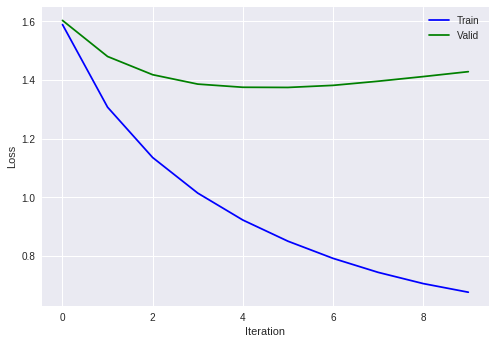

In [0]:
#plot training and validations losses each epoch
plot_losses(metrics)